# Problem Statement
Farmers who grow potatoes suffer from serious financial standpoint losses each year which cause several diseases that affect potato plants. The diseases **Early Blight** and **Late Blight** are the most frequent.

**Early blight** is a disease of potato caused by the *fungus Alternaria solani*. It is found wherever potatoes are grown. The disease primarily affects leaves and stems, but under favorable weather conditions, and if left uncontrolled, can result in considerable defoliation and enhance the chance for tuber infection.

**Late blight** caused by the *Phytophthora infestans* is the most important disease of potato that can result into crop failures in a short period if appropriate control measures are not adopted.

Early blight is caused by **fungus** and late blight is caused by specific **micro-organisms** and if farmers detect this disease early and apply appropriate treatment then it can save a lot of waste and prevent economical loss. The treatments for early blight and late blight are a little different so it’s important that you accurately identify what kind of disease is there in that potato plant.

**Our Goal is to classify the the type of disease in the potato plant**
Thus, we have three classes 


*   Healthy
*   Early Blight
*   Late Blight


### Setting up kaggle api for getting the datset
for that you can go to kaggle.com-> your profile-> Account-> Create New API Token

Then upload the kaggle.json file in google collab and then run the below commands

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


**Put the name of the dataset that you want to use and then unzip the dataset**

In [ ]:
! kaggle datasets download arjuntejaswi/plant-village

In [2]:
! unzip /content/PlantVillage.zip

Archive:  /content/PlantVillage.zip
   creating: PlantVillage/
  inflating: __MACOSX/._PlantVillage  
   creating: PlantVillage/Potato___Early_blight/
  inflating: __MACOSX/PlantVillage/._Potato___Early_blight  
   creating: PlantVillage/Potato___Late_blight/
  inflating: __MACOSX/PlantVillage/._Potato___Late_blight  
   creating: PlantVillage/Potato___healthy/
  inflating: __MACOSX/PlantVillage/._Potato___healthy  
  inflating: PlantVillage/Potato___Early_blight/acb84d77-5b1c-4beb-be27-99fee467bf1f___RS_Early.B 7577.JPG  
  inflating: __MACOSX/PlantVillage/Potato___Early_blight/._acb84d77-5b1c-4beb-be27-99fee467bf1f___RS_Early.B 7577.JPG  
  inflating: PlantVillage/Potato___Early_blight/bc7552e4-3901-41b8-8bef-727eeca4270e___RS_Early.B 7942.JPG  
  inflating: __MACOSX/PlantVillage/Potato___Early_blight/._bc7552e4-3901-41b8-8bef-727eeca4270e___RS_Early.B 7942.JPG  
  inflating: PlantVillage/Potato___Early_blight/1994cd3e-4000-4c56-bede-d35a1eecc287___RS_Early.B 6867.JPG  
  inflating: 

# Importing Essential libs

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [52]:
# Constant values that we are going to use 
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 #RGB
EPOCHS = 20

# Exploraotry Data Analysis

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle="True",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
# Classes which are present in the dataset as a folder name
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [7]:
len(dataset)

68

here 68 is the number of batches and batch size is 32 so total length of dataset is 68*32

In [9]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 0 0 1 0 1 1 0 0 2 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 1]


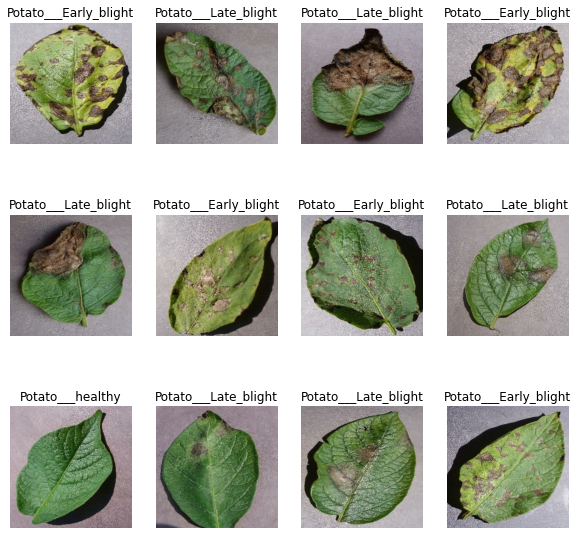

In [12]:
# Some images of both the diseases
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(0,12):
    ax = plt.subplot(3,4,i+1)
    plt.title(class_names[label_batch[i]])
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")

# Data Preparation and Model Training:

**Used splitfolders tool to split dataset into training, validation and test directories.**

In [67]:
!pip install split-folders
!splitfolders --ratio 0.8 0.1 0.1 -- ./PlantVillage/

Copying files: 2152 files [00:00, 5747.73 files/s]


## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

### Data Augmentation 
Data Augmentation is needed when we have less data or when we want to make our model robust, we do this to boost the accuracy of our model.

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
#         save_to_dir="training\\AugmentedImages"
)

Found 1721 images belonging to 3 classes.


In [85]:
train_generator.class_indices

{'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}

In [86]:
class_names = list(train_generator.class_indices.keys())
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [87]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 215 images belonging to 3 classes.


In [88]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 216 images belonging to 3 classes.


### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

In [90]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [91]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 30, 30, 64)      

### Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [92]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [93]:
history = model.fit(
    train_generator,
    steps_per_epoch=47,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=20,
)

Epoch 1/20
47/47 [==============================] - 28s 582ms/step - loss: 0.9170 - accuracy: 0.5010 - val_loss: 0.8718 - val_accuracy: 0.4896
Epoch 2/20
47/47 [==============================] - 27s 574ms/step - loss: 0.7157 - accuracy: 0.6620 - val_loss: 0.5088 - val_accuracy: 0.8125
Epoch 3/20
47/47 [==============================] - 28s 599ms/step - loss: 0.4837 - accuracy: 0.7923 - val_loss: 0.4023 - val_accuracy: 0.8385
Epoch 4/20
47/47 [==============================] - 27s 584ms/step - loss: 0.3548 - accuracy: 0.8490 - val_loss: 0.2780 - val_accuracy: 0.8802
Epoch 5/20
47/47 [==============================] - 29s 607ms/step - loss: 0.2876 - accuracy: 0.8831 - val_loss: 0.2636 - val_accuracy: 0.8906
Epoch 6/20
47/47 [==============================] - 28s 586ms/step - loss: 0.2394 - accuracy: 0.9031 - val_loss: 0.2047 - val_accuracy: 0.9115
Epoch 7/20
47/47 [==============================] - 28s 586ms/step - loss: 0.2620 - accuracy: 0.9058 - val_loss: 0.3919 - val_accuracy: 0.8698

In [95]:
scores = model.evaluate(test_generator)

7/7 [==============================] - 4s 551ms/step - loss: 0.0828 - accuracy: 0.9722


**You can see above that we get 97% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [96]:
scores

[0.08284460008144379, 0.9722222089767456]

**Scores is just a list containing loss and accuracy value**

## Plotting the Accuracy and Loss Curves

In [97]:
history

In [98]:
history.params

{'epochs': 20, 'steps': 47, 'verbose': 1}

In [99]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

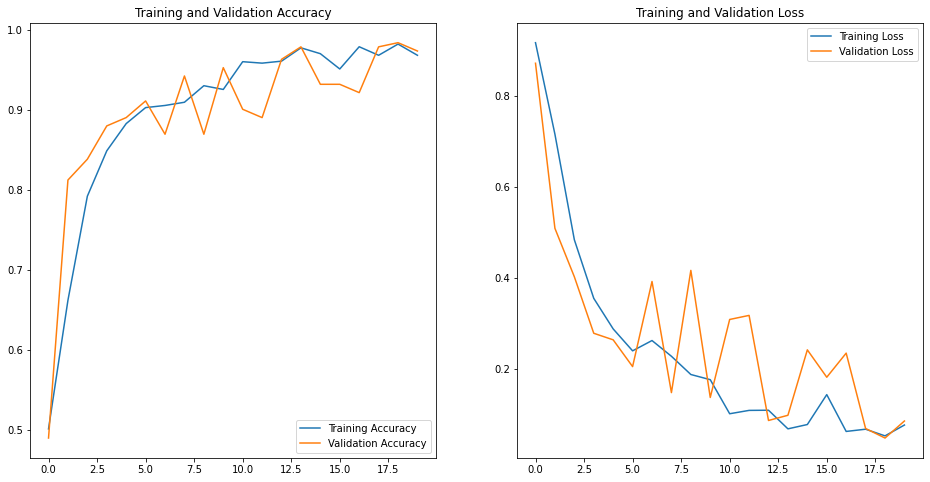

In [101]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


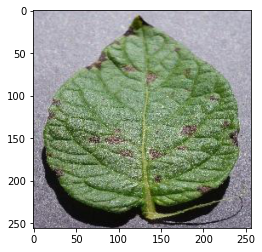

In [109]:
import numpy as np


for image_batch, label_batch in test_generator:
    first_image = image_batch[0]
    first_label = int(label_batch[0])
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    
    break

# function for inference

In [112]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

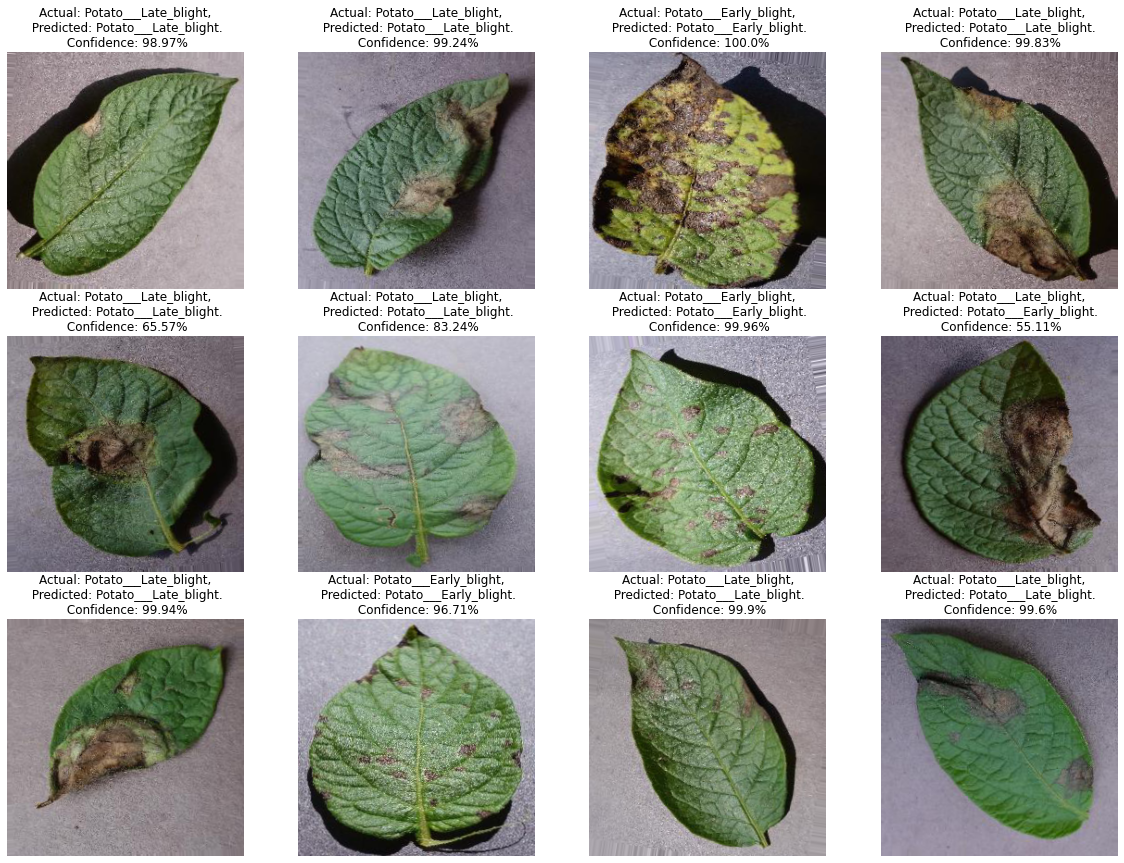

In [116]:
plt.figure(figsize=(20, 20))
for images, labels in test_generator:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[int(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Saving the model in h5 format

In [37]:
model.save("potatoes.h5")